In [3]:
import requests
import os, sys, shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import magic
from zipfile import ZipFile
from datetime import datetime,timedelta
import cv2

## Objectives - Target vs. Features, General Plan

# 1 | Data Collection 

## 1.1 | Data Loading 

For this project, there are two key datasets with image data and class labels (Glaucoma vs. Normal), both of which are relatively large but can be downloaded via CLI.  Some helpful functions for more consistent downloading:

In [2]:
# Custom function for extracting zip file in more organized way
def unzip(zfpath,outpath):
    with ZipFile(zfpath,'r') as zipref:
        if not os.path.exists(outpath):
            os.mkdir(outpath)
        zipref.extractall(outpath)
        print(f'Contents of {os.path.basename(zfpath)} extracted to {outpath}')

# Function for downloading zip file from Zenodo and extracting into proper folder 
def download_datazip(url,dirname,parentDIR='../datasrc/',report_time=True):
    
    '''Downloads from provided link of a zip file, automatically extracting to 
    a specified folder name inside of the datasrc/ directory of this project.  
    If extraction is successful, the original zip file will be removed to save
    space / avoid redundancy.

    PARAMS
    ------
        url        :     Link to zip file.
        
        dirname    :     Name of directory to extract contents of zip file into
                         this will be located within `parentDIR`, which by default
                         is the `datasrc/` directory of the main project directory.
                         If path does not yet exist, it will be created.
        
        parentDIR  :     Path to directory where `dirname` is or will be created. 
                         By default, this is `../datasrc/`

        report_time:     If `True` (default), will print out the start and end times 
                         of the download, and report total time.
    '''
    
    targetPATH = os.path.join(parentDIR,dirname)
    zipfilePATH = targetPATH + '.zip'

    if report_time:
        # Start Time
        t_start = datetime.now()
        
    #-----------------#
    # Download zipfile
    print('Requesting data...')
    response = requests.get(url)
    filesize = sys.getsizeof(response.content)
    with open(zipfilePATH,'wb') as f:
        f.write(response.content)
    print(f'Downloaded zip file ({filesize:,.02f} bytes) to {zipfilePATH}')

    # Extract zip to target path
    try:
        unzip(zipfilePATH,targetPATH)
    except:
        raise NotImplementedError(f"Issue with either locating/creating {targetPATH},\
        extracting {zipfilePATH}, or removing {zipfilePATH} after extraction.")   
        
    # Remove zip file if successful
    os.remove(zipfilePATH)
    print(f'Removed {os.path.basename(zipfilePATH)} after extraction.')
    #-----------------#
    
    if report_time:
        # End Time
        t_end = datetime.now()
        # Time Report
        tdif = (t_end - t_start).total_seconds()
        if tdif > 3600:
            unit = 'hours'
            tdif = tdif / 3600
        elif tdif > 60 and tdif < 3600:
            unit = 'minutes'
            tdif = tdif / 60
        else:
            unit = 'seconds'
        print(f'Time Elapsed: {tdif:.4f} {unit}')

### SET 1: OCT Volumes (3D)

The data downloaded here are from the <i>[OCT volumes for glaucoma detection](https://zenodo.org/records/1481223)</i> dataset, published to **Zenodo** by Hiroshi Ishikawa from NYU, one of the authors of <i>[A feature agnostic approach for glaucoma detection in OCT volumes. (PLOS One, 2019)](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0219126)</i>.  

NOTE: per the authors, the dataset only includes Optic Nerve Head (ONH) centered OCT Scans as 3D volumes in numpy format (`.npy` file extension).  The scans were originally 6 x 6 x 2 mm, corresponding to 200 x 200 x 1024 voxels, but were downsampled to 64 x 64 x 128 for the sake of computation.

<u>Downloading OCT Volumes</u>

In [8]:
# Download OCT volumes (v for volume)
vURL="https://zenodo.org/records/1481223/files/glaucoma_detection.zip?download=1"
vDIR = 'volumesOCT'
vPATH = os.path.join('../datasrc/',vDIR)
download_datazip(vURL,vDIR)

### SET 2: Composite Fundus & OCT Images (2D)

These data come from [A Composite Retinal Fundus and OCT Dataset with Detailed Clinical Markings of Retinal Layers and Retinal Lesions to Grade Macular and Glaucomatous Disorders](https://data.mendeley.com/datasets/trghs22fpg/4), published by Taimur Hassan et al. (National University of Sciences and Technology, Khalifa University of Science and Technology) to **Mendeley**.  Note that this is the 4th version (most recent as of June 2025) published September 22, 2021, while the very first version was released Martch 18, 2021.

In [ ]:
# Download zip file for fundus-oct-composite (foc) dataset & extract
focURL = "https://prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com/trghs22fpg-4.zip"
download_datazip(focURL,'fundus-oct-composite')

# Inside the downloaded zip file is another zip file... so extract again
unzip('../datasrc/fundus-oct-composite/Dataset.zip','../datasrc/fundus-oct-composite/')
os.remove('../datasrc/fundus-oct-composite/Dataset.zip')

# Cut out redundant directory levels
foclongpath = '../datasrc/fundus-oct-composite/Dataset/Dataset/OD/'
focPATH = '/'.join(foclongpath.split('/')[:3])
for i in os.listdir(foclongpath):
    old = os.path.join(foclongpath,i)
    new = os.path.join(focPATH,i)
    os.rename(old,new)

# Discard irrelevant directories
shutil.rmtree(os.path.join(focPATH,'Dataset')
os.listdir('../datasrc/fundus-oct-composite/')

## 1.2 | Data Joining

As the data types between the two sets, along with directory structure differ, will save this step for after defining data types and potentially applying transformations to make them more compatible.

# 2 | Data Organization 

## 2.1 |  File Structure

### SET 1

For the OCT Volumes, the entirety of the dataset is a bunch of `.npy` files, containing the volume data for each OCT scan. 

In [9]:
os.listdir(vPATH)[:10]

['POAG-001978-2012-02-08-OS.npy',
 'Normal-002743-2009-03-26-OS.npy',
 'POAG-001086-2008-08-04-OS.npy',
 'POAG-000092-2010-12-14-OS.npy',
 'POAG-003223-2014-01-10-OD.npy',
 'POAG-002534-2008-10-21-OD.npy',
 'POAG-002853-2013-09-19-OD.npy',
 'POAG-002516-2016-09-01-OS.npy',
 'POAG-000695-2008-11-13-OS.npy',
 'Normal-002016-2010-03-25-OS.npy']

It appears any tabular data is encoded in the names of each file, such as the class label (Normal vs. POAG ,where POAG = Primary Open-Angle Glaucoma).

In [13]:
# Save list of volume file names to volNames for later use
volNames = os.listdir(vPATH)

### SET 2

In [7]:
os.listdir('../datasrc/fundus-oct-composite/')[:10]

['Glaucoma', 'Healthy']

## 2.2 | GitHub Repository Information 

# 3 | Data Definition

## 3.1 | Extraction of Tabular Data

As noted earlier, while both datasets are primarily image data, the file structure/naming encodes some potentially useful tabular information, at least from the perspective of organization & matching them to classification target labels.

### SET 1

In [19]:
# Display examples of filenames
volNames[64:66]

['Normal-003102-2009-09-03-OS.npy', 'POAG-000671-2009-07-30-OS.npy']

Based on the file naming convention seen above, we can establish column names based on what they represent, and then extract the values for each file into columns of a dataframe:

In [18]:
# Establish names for basic components to of the filename to split
vcols = "dx_class patient_id date laterality filename".split(' ')

# Initialize lists for each feature
dxs = []; pids = []; dates = []; lats = []

# Iterate through all filenames, extracting out the feature values and appending to lists
for name in volNames:   
    dx, pid, yr, mo, d, lat = name.strip('.npy').split('-')

    # combine the date elements (year,month,day) into a single datetime object
    dtstring = '-'.join([yr,mo,d])
    dt = datetime.strptime(dtstring,'%Y-%m-%d')
    
    dates.append(dt)
    dxs.append(dx)
    pids.append(pid)
    lats.append(lat)

# Combine resulting feature lists into a sample/data array, and transpose (for pandas format)
tbldata = np.array([ dxs, pids, dates, lats, volNames ]).T

# Convert to DataFrame
voluMetadata = pd.DataFrame(tbldata,columns=vcols)
voluMetadata.head()

dx_class patient_id       date laterality                         filename
0     POAG     001978 2012-02-08         OS    POAG-001978-2012-02-08-OS.npy
1   Normal     002743 2009-03-26         OS  Normal-002743-2009-03-26-OS.npy
2     POAG     001086 2008-08-04         OS    POAG-001086-2008-08-04-OS.npy
3     POAG     000092 2010-12-14         OS    POAG-000092-2010-12-14-OS.npy
4     POAG     003223 2014-01-10         OD    POAG-003223-2014-01-10-OD.npy

### SET 2 

In [22]:
iPATH = '../datasrc/fundus-oct-composite/'
os.listdir(iPATH)

['Glaucoma', 'Healthy']

The 2D image dataset appears to have a more complicated file hierarchy, and the equivalent tabular information seem to be encoded in the full path rather than just file names.  Using the `glob` library, we can look for all paths (in this case all leading to files, which are hopefully all images):

In [28]:
# Within iPATH, get all paths that lead to *.* (i.e., assuming this would be a file)
filePaths = glob.glob(os.path.join(iPATH,'**','*.*'),recursive=True)

# Preview some of the file paths
filePaths[:5]

['../datasrc/fundus-oct-composite/Glaucoma/P_26/Right Eye/99144_20140909_173003_Color_R_001.jpg',
 '../datasrc/fundus-oct-composite/Glaucoma/P_26/Right Eye/99144_20140909_173003_B-scan_R_001.jpg',
 '../datasrc/fundus-oct-composite/Glaucoma/P_26/Right Eye/99144_20140909_173003_Red-free_R_001.jpg',
 '../datasrc/fundus-oct-composite/Glaucoma/P_26/Left Eye/99144_20140909_173131_Red-free_L_001.jpg',
 '../datasrc/fundus-oct-composite/Glaucoma/P_26/Left Eye/99144_20140909_173131_Color_L_001.jpg']

These all look like `.jpg` image files, but to be sure, let's apply `magic.from_file()` method to check the MIME-types:

In [33]:
# Ensure all of these files are are images
imgPaths = [ fp for fp in imgPaths if magic.from_file(fp,mime=True).startswith('image') ]

# Preview a few image paths
imgPaths[10:15]

['../datasrc/fundus-oct-composite/Glaucoma/P_6/Right Eye/Fundus_Right_Glaucoma_Cup.jpg',
 '../datasrc/fundus-oct-composite/Glaucoma/P_6/Right Eye/1910153_20151019_102803_B-scan_R_001.jpg',
 '../datasrc/fundus-oct-composite/Glaucoma/P_6/Right Eye/OCT_Right_Glaucoma_Cup.jpg',
 '../datasrc/fundus-oct-composite/Glaucoma/P_6/Right Eye/1910153_20151019_102803_Color_R_001.jpg',
 '../datasrc/fundus-oct-composite/Glaucoma/P_6/Right Eye/Fundus_Right_Glaucoma_Disc.jpg']

In [34]:
# Check if all paths descend an equal number of levels
list(set([ len(ip.split('/')) for ip in imgPaths ]))

[7]

All paths descend 7 levels, so this can make for a consistent number of columns based on `/`  as the delimiter.  But the first few levels are notably just `iPATH`, so we can cut that out:

In [48]:
# Cut out the first part
subpaths = [ ip.split(iPATH)[-1] for ip in imgPaths ]
midIdx = int(len(subpaths)/2)
print(len(subpaths))
subpaths[midIdx:midIdx+10]

# Get filenames
imgNames = [ sp.split('/')[-1] for sp in subpaths ]
imgNames[10:30]

417


['Fundus_Right_Glaucoma_Cup.jpg',
 '1910153_20151019_102803_B-scan_R_001.jpg',
 'OCT_Right_Glaucoma_Cup.jpg',
 '1910153_20151019_102803_Color_R_001.jpg',
 'Fundus_Right_Glaucoma_Disc.jpg',
 'OCT_Right_Glaucoma_Disc.jpg',
 '1910153_20151019_102937_B-scan_L_001.jpg',
 '1910153_20151019_102937_Color_L_001.jpg',
 '1910153_20151019_102937_Red-free_L_001.jpg',
 'Fundus_Left_Glaucoma_Cup.jpg',
 'OCT_Left_Glaucoma_Disc.jpg',
 'Fundus_Left_Glaucoma_Disc.jpg',
 'OCT_Left_Glaucoma_Cup.jpg',
 '10915787_20150910_110142_Red-free_R_001.jpg',
 'Fundus_Right_Glaucoma_Cup.jpg',
 'OCT_Right_Glaucoma_Cup.jpg',
 '10915787_20150910_110142_Color_R_001.jpg',
 'Fundus_Right_Glaucoma_Disc.jpg',
 '10915787_20150910_110142_B-scan_R_001.jpg',
 'OCT_Right_Glaucoma_Disc.jpg']

Of note, some of these images are also Fundus images, so will need to subset only OCT scans to hopefully get some compatibility with the other dataset.  

Some general categories of images can be identified based on the name, such as "B-scan", "Fundus", "Color", etc. but to be sure we know all the categories, let's extract image-type labels more systemmatically based on word frequencies.  

Since these are just short filenames and not full documents, using sparse matrices and `sklearn` tools like `TfidfVectorizer` and/or `CountVectorizer` would likely be overkill - instead, `collections.Counter` should be sufficient.

In [82]:
# First split up all image filenames into individual "words" (tokens).
import re
# set of terms "words" we know in advance not to be scan types
stopwords = {'jpg', 'glaucoma', 'normal', 'left', 'right', 'l', 'r'}

# Initialize list of tokens
tokens = []

# split all image names into tokens, weeding out those in stopwords
# and those that are entirely numeric
for name in imgNames:
    
    parts = [
        p for p in re.split(r'[_\.]',name.lower())
        if p not in stopwords
        if not p.isnumeric()
    ]   
    
    tokens.extend(parts)

uniqTokens = list(set(tokens))

uniqTokens

['oct',
 '001#1',
 'cyst',
 'fundus',
 'b-scan',
 'color',
 'disc',
 'red-free',
 'cup',
 'me']

Some tokens immediately appear suspicious, such as `001#1` and `me`, and some may be subcategories of categories represented by other tokens.  That's where `Counter` / token frequency comes in:

In [86]:
from collections import Counter
tknCount = Counter(tokens)
tknCount.most_common(50)

[('oct', 91),
 ('cup', 90),
 ('fundus', 89),
 ('disc', 89),
 ('b-scan', 80),
 ('color', 79),
 ('red-free', 78),
 ('001#1', 2),
 ('me', 1),
 ('cyst', 1)]

In [115]:
imgTypes = [ token for token,count in tknCount.items() if count > 10 ]
print(len(imgTypes))
imgTypes

7


['color', 'b-scan', 'red-free', 'fundus', 'cup', 'oct', 'disc']

In [119]:
sample_imgs = {}

for name in imgNames:
    for img_type in imgTypes:
        if img_type in name.lower() and img_type not in sample_imgs:
            sample_imgs[img_type] = name
        if len(sample_imgs) == len(imgTypes):
            break
    if len(sample_imgs) == len(imgTypes):
        break

# Result: list of one example per image type
sampleImages = list(sample_imgs.values())
print(len(sampleImages)); sampleImages

7


['99144_20140909_173003_Color_R_001.jpg',
 '99144_20140909_173003_B-scan_R_001.jpg',
 '99144_20140909_173003_Red-free_R_001.jpg',
 'Fundus_Right_Glaucoma_Cup.jpg',
 'Fundus_Right_Glaucoma_Cup.jpg',
 'OCT_Right_Glaucoma_Cup.jpg',
 'Fundus_Right_Glaucoma_Disc.jpg']

Looks like 'cup' is a subcategory of multiple categories, so `Fundus_Right_Glaucoma_Cup.jpg` is duplicated here.  Since already know we don't want Fundus images, we can simply remove from `imgTypes`:

In [121]:
nonOCTs = []
nonOCTs.append(imgTypes.pop(imgTypes.index('fundus')))
nonOCTs,imgTypes

(['fundus'], ['color', 'b-scan', 'red-free', 'cup', 'oct', 'disc'])

In [125]:
sample_imgs = {}

for name in imgNames:
    for ityp in imgTypes:
        if ityp in name.lower() and ityp not in sample_imgs:
            for noct in nonOCTs:
                if noct not in name.lower():
                    sample_imgs[ityp] = name
        if len(sample_imgs) == len(imgTypes):
            break

sampleImages = list(sample_imgs.values())
print(len(sampleImages)); sampleImages

6


['99144_20140909_173003_Color_R_001.jpg',
 '99144_20140909_173003_B-scan_R_001.jpg',
 '99144_20140909_173003_Red-free_R_001.jpg',
 'OCT_Right_Glaucoma_Cup.jpg',
 'OCT_Right_Glaucoma_Cup.jpg',
 'OCT_Right_Glaucoma_Disc.jpg']

In [126]:
sampleImgPaths = []
for sImg in sampleImages:
    paths = [ p for p in imgPaths if sImg in p ]
    if paths != []:
        sampleImgPaths.append(paths[0])
len(sampleImgPaths)

6

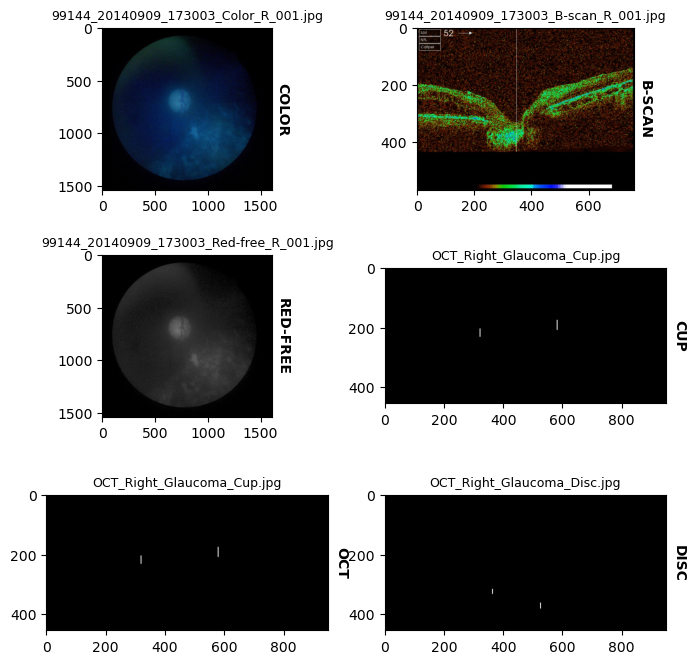

In [164]:
fig,ax = plt.subplots(3,2,figsize=(8,8))

for i,ip in enumerate(sampleImgPaths):
    img = cv2.imread(ip)
    w = img.shape[0]
    ax.flat[i].imshow(img)
    ax.flat[i].set_title(sampleImages[i],fontsize=9)
    
    ax.flat[i].text(1.02,0.5,
                    f'{imgTypes[i].upper()}',
                    rotation=-90, 
                    transform=ax.flat[i].transAxes,
                    va='center',
                    fontweight='bold')
    
plt.subplots_adjust(hspace=.4)

In [245]:
13 % 2

1

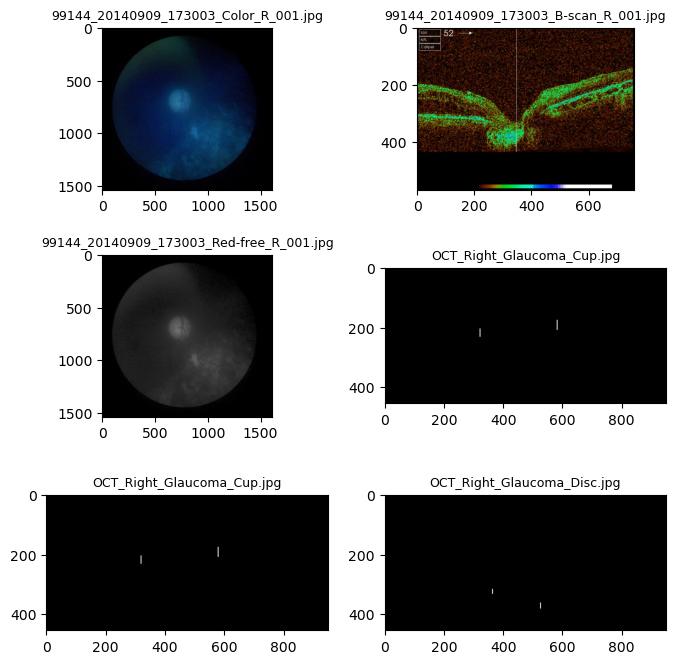

In [247]:
def imPanelShow(images):
    imageArrays=[]
    for i in images:
        if os.path.isfile(i):
            i = cv2.imread(i)
        if type(i) == np.ndarray:
            imageArrays.append(i)

    ncols = 2
    nrows = int(len(imageArrays)/2)
    if len(imageArrays) % 2 != 0:
        nrows += 1
    
    fig,ax = plt.subplots(nrows,ncols,figsize=(8,8))
    
    for i,img in enumerate(imageArrays):
        # w,h = img.shape
        ax.flat[i].imshow(img)
        
        if type(images[i]) == str:
            title=images[i].split('/')[-1]
        else:
            title=str(i)
            
        ax.flat[i].set_title(title,fontsize=9)
        
        # ax.flat[i].text(1.02,0.5,
        #                 f'{imgTypes[i].upper()}',
        #                 rotation=-90, 
        #                 transform=ax.flat[i].transAxes,
        #                 va='center',
        #                 fontweight='bold')
    
    plt.subplots_adjust(hspace=.4)
        
imPanelShow(sampleImgPaths)

So it seems the only image types that may seem relevant are the ones that include 'OCT' or 'B-scan' in their name.  Otherwise, they seem to be variations of fundus photography. 

In [165]:
imgTypes

['color', 'b-scan', 'red-free', 'cup', 'oct', 'disc']

In [178]:
octNames = [n for n in imgNames if 'oct' in n.lower() or 'b-scan' in n.lower()]
octNames = list(set(octNames))
len(octNames)

85

In [170]:
OCTpaths = []

# for n in OCTnames:
#     foundpaths = [path for path in imgPaths if n in path]
#     if len(foundpaths) == 1:
#         OCTpaths.append(foundpaths[0])
#     else:
#         print(f"{len(foundpaths)} paths found that end in {n}")
    
len(OCTpaths)

0

In [179]:
octPaths = []

for n in octNames:
    foundpaths = [path for path in imgPaths if n in path]
    octPaths.append(foundpaths[0])
    
len(octPaths)

85

In [180]:
bscnPaths = [ p for p in octPaths if 'b-scan' in p.lower() ]
len(bscnPaths)

76

In [181]:
bscnPaths[20:40]

['../datasrc/fundus-oct-composite/Glaucoma/P_21/Left Eye/0809142_20140908_103145_B-scan_L_001.jpg',
 '../datasrc/fundus-oct-composite/Glaucoma/P_24/Right Eye/0808145_20140808_120742_B-scan_R_001.jpg',
 '../datasrc/fundus-oct-composite/Glaucoma/P_17/Right Eye/09091422_20140909_152236_B-scan_R_001.jpg',
 '../datasrc/fundus-oct-composite/Glaucoma/P_15/Left Eye/05091418_20140905_190938_B-scan_L_001.jpg',
 '../datasrc/fundus-oct-composite/Healthy/P_16/Right Eye/09091426_20140909_180001_B-scan_R_001.jpg',
 '../datasrc/fundus-oct-composite/Glaucoma/P_16/Left Eye/09091428_20140909_183107_B-scan_L_001.jpg',
 '../datasrc/fundus-oct-composite/Healthy/P_3/Right Eye/1491511221_20150914_123434_B-scan_R_001.jpg',
 '../datasrc/fundus-oct-composite/Glaucoma/P_20/Right Eye/09091420_20140909_145543_B-scan_R_001.jpg',
 '../datasrc/fundus-oct-composite/Glaucoma/P_18/Right Eye/1091413_20140910_151948_B-scan_R_001.jpg',
 '../datasrc/fundus-oct-composite/Glaucoma/P_15/Right Eye/05091418_20140905_190810_B-scan

In [182]:
octSubPaths = [ p.split(iPATH)[-1] for p in octPaths ]
octSubPaths[0]

'Glaucoma/P_8/Left Eye/109151_20150910_080411_B-scan_L_001.jpg'

In [185]:
oct2D = pd.DataFrame({'filepath':octPaths})
oct2D.head()

filepath
0  ../datasrc/fundus-oct-composite/Glaucoma/P_8/L...
1  ../datasrc/fundus-oct-composite/Glaucoma/P_5/L...
2  ../datasrc/fundus-oct-composite/Glaucoma/P_12/...
3  ../datasrc/fundus-oct-composite/Glaucoma/P_25/...
4  ../datasrc/fundus-oct-composite/Healthy/P_6/Ri...

In [196]:
oct2D.filepath.str.lower().str.contains('b-scan').sum()

76

In [197]:
feats2D = 'dx_class pid laterality filename'.split(' ')

for i,f in enumerate(feats2D):
    oct2D[f] = oct2D.filepath.str.split('/').str[i+3]

oct2D['b-scan'] = oct2D.filepath.str.lower().str.contains('b-scan')


oct2D = oct2D[feats2D + ['b-scan','filepath']].sort_values('pid').drop('filename',axis=1)
oct2D.head()

dx_class   pid laterality  b-scan  \
76   Healthy   P_1  Right Eye    True   
20   Healthy   P_1   Left Eye    True   
51  Glaucoma   P_1   Left Eye    True   
82  Glaucoma  P_10   Left Eye    True   
15   Healthy  P_10   Left Eye    True   

                                             filepath  
76  ../datasrc/fundus-oct-composite/Healthy/P_1/Ri...  
20  ../datasrc/fundus-oct-composite/Healthy/P_1/Le...  
51  ../datasrc/fundus-oct-composite/Glaucoma/P_1/L...  
82  ../datasrc/fundus-oct-composite/Glaucoma/P_10/...  
15  ../datasrc/fundus-oct-composite/Healthy/P_10/L...

In [211]:
oct2D.value_counts('pid')

pid
P_6     12
P_5      5
P_9      4
P_2      4
P_8      4
P_12     4
P_4      4
P_3      4
P_18     4
P_10     4
P_7      3
P_1      3
P_16     3
P_11     3
P_20     2
P_19     2
P_22     2
P_23     2
P_24     2
P_25     2
P_26     2
P_17     2
P_15     2
P_14     2
P_13     2
P_21     2
Name: count, dtype: int64

In [199]:
oct2D[~oct2D['b-scan']]['filepath'].str.split('/').str[-1]

1            OCT_Left_ME_Cyst.jpg
66     OCT_Right_Glaucoma_Cup.jpg
58        OCT_Left_Normal_Cup.jpg
84     OCT_Left_Glaucoma_Disc.jpg
59       OCT_Right_Normal_Cup.jpg
65    OCT_Right_Glaucoma_Disc.jpg
45       OCT_Left_Normal_Disc.jpg
27      OCT_Left_Glaucoma_Cup.jpg
4       OCT_Right_Normal_Disc.jpg
Name: filepath, dtype: object

In [252]:
len(oct2D), len(oct2D[oct2D['b-scan']]), len(oct2D[~oct2D['b-scan']])

(85, 76, 9)

In [257]:
oct2D[oct2D.filepath.str.contains('Disc|Cup',regex=True)]

dx_class  pid laterality  b-scan  \
66  Glaucoma  P_6  Right Eye   False   
58   Healthy  P_6   Left Eye   False   
84  Glaucoma  P_6   Left Eye   False   
59   Healthy  P_6  Right Eye   False   
65  Glaucoma  P_6  Right Eye   False   
45   Healthy  P_6   Left Eye   False   
27  Glaucoma  P_6   Left Eye   False   
4    Healthy  P_6  Right Eye   False   

                                             filepath  
66  ../datasrc/fundus-oct-composite/Glaucoma/P_6/R...  
58  ../datasrc/fundus-oct-composite/Healthy/P_6/Le...  
84  ../datasrc/fundus-oct-composite/Glaucoma/P_6/L...  
59  ../datasrc/fundus-oct-composite/Healthy/P_6/Ri...  
65  ../datasrc/fundus-oct-composite/Glaucoma/P_6/R...  
45  ../datasrc/fundus-oct-composite/Healthy/P_6/Le...  
27  ../datasrc/fundus-oct-composite/Glaucoma/P_6/L...  
4   ../datasrc/fundus-oct-composite/Healthy/P_6/Ri...

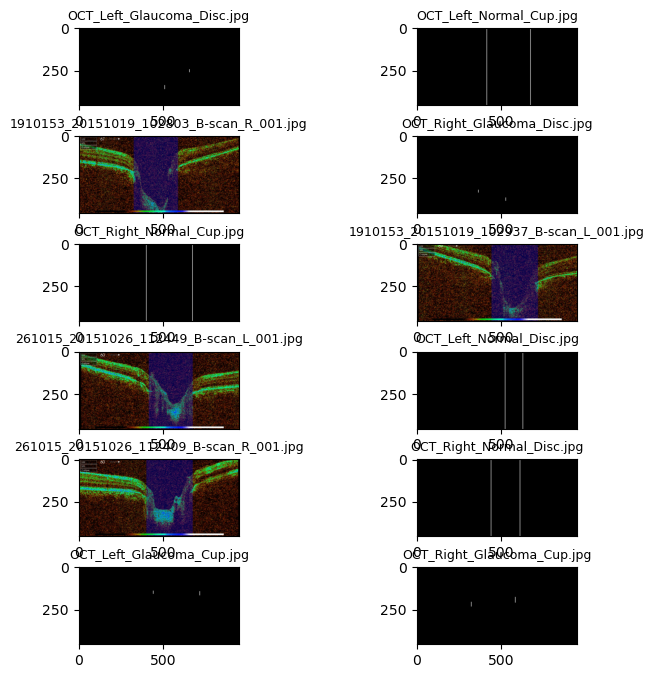

In [260]:
imPanelShow(ptscans(0))

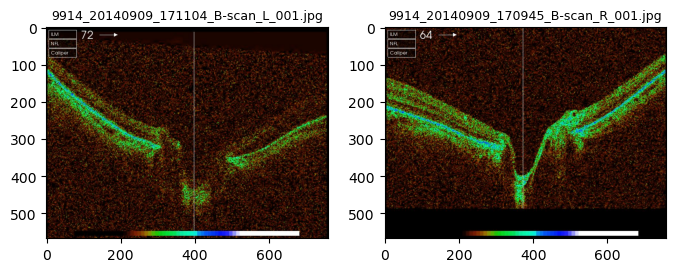

In [262]:
imPanelShow(ptscans(1))

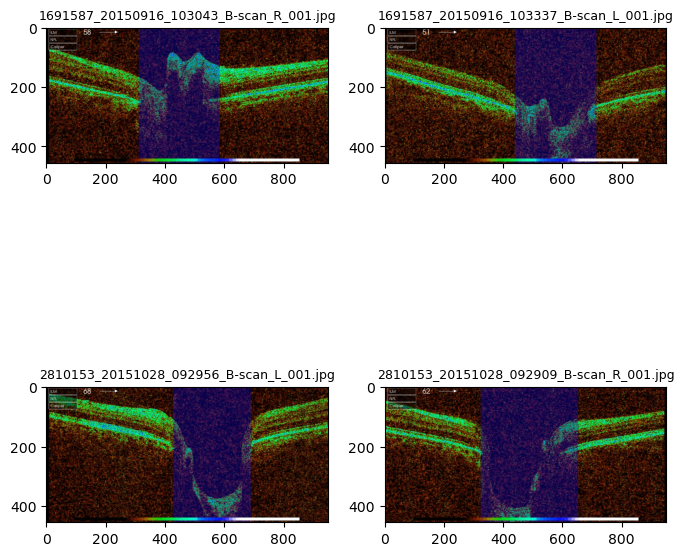

In [263]:
imPanelShow(ptscans(2))

In [268]:
ptscans(2)[1]
# plt.imshow(cv2.imread(ptscans(2)[1]))

'../datasrc/fundus-oct-composite/Glaucoma/P_10/Left Eye/1691587_20150916_103337_B-scan_L_001.jpg'

In [293]:
img = cv2.imread(ptscans(2)[1])
img.shape

(456, 951, 3)

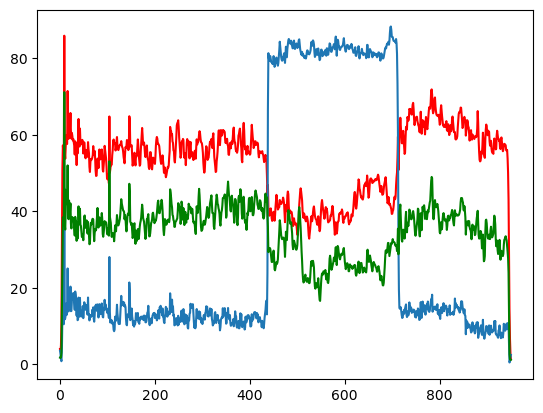

In [302]:
blue = img[:, :, 2].mean(axis=0)
green = img[:, :, 1].mean(axis=0)
red = img[:, :, 0].mean(axis=0)

plt.plot(red,c='red')
plt.plot(blue)
plt.plot(green,c='green')

In [303]:
threshold_b = 50
threshold_g = 50
threshold_r = 50

shaded_cols = np.where((blue > threshold_b) & (green < threshold_g) & (red < threshold_r))[0]
shaded_cols

array([438, 439, 440, 441, 442, 443, 444, 445, 446, 447, 448, 449, 450,
       451, 452, 453, 454, 455, 456, 457, 458, 459, 460, 461, 462, 463,
       464, 465, 466, 467, 468, 469, 470, 471, 472, 473, 474, 475, 476,
       477, 478, 479, 480, 481, 482, 483, 484, 485, 486, 487, 488, 489,
       490, 491, 492, 493, 494, 495, 496, 497, 498, 499, 500, 501, 502,
       503, 504, 505, 506, 507, 508, 509, 510, 511, 512, 513, 514, 515,
       516, 517, 518, 519, 520, 521, 522, 523, 524, 525, 526, 527, 528,
       529, 530, 531, 532, 533, 534, 535, 536, 537, 538, 539, 540, 541,
       542, 543, 544, 545, 546, 547, 548, 549, 550, 551, 552, 553, 554,
       555, 556, 557, 558, 559, 560, 561, 562, 563, 564, 565, 566, 567,
       568, 569, 570, 571, 572, 573, 574, 575, 576, 577, 578, 579, 580,
       581, 582, 583, 584, 585, 586, 587, 588, 589, 590, 591, 592, 593,
       594, 595, 596, 597, 598, 599, 600, 601, 602, 603, 604, 605, 606,
       607, 608, 609, 610, 611, 612, 613, 614, 615, 616, 617, 61

In [311]:
imgCR1 = img[:,shaded_cols,:]
w,h,a = imgCR1.shape
# imgCR1.shape
w/h

1.6764705882352942

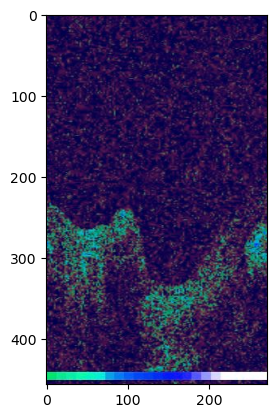

In [312]:
plt.imshow(imgCR1)

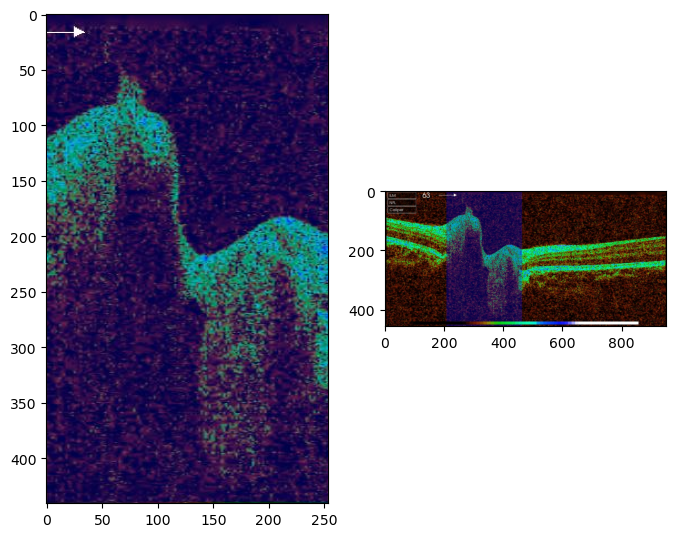

In [343]:
def cropBSCAN(img,BGRthresh=(50,50,50),explore=False,showMode=None):

    if os.path.isfile(img):
        img = cv2.imread(img)

    # Crop out bottom scalebar
    row_scores = np.abs(np.diff(img.astype(int),axis=0)).mean(axis=(1,2))
    indices = np.where(row_scores[::-1] > 50)[0]
    top_of_band = img.shape[0] - indices.max() - 1
    imgbc = img[:top_of_band,:,:]

    # Crop out sides based on color transition
    blue = imgbc[:, :, 2].mean(axis=0)
    green = imgbc[:, :, 1].mean(axis=0)
    red = imgbc[:, :, 0].mean(axis=0)
    
    if explore:
        plt.plot(red,c='red')
        plt.plot(blue,c='blue')
        plt.plot(green,c='green')
    else:
        threshold_b, threshold_g, threshold_r = BGRthresh
        shaded_cols = np.where((blue > threshold_b) & (green < threshold_g) & (red < threshold_r))[0]
        cropped_image = imgbc[:,shaded_cols,:]
        if showMode == 'compare':
            fig,(l,r) = plt.subplots(1,2,figsize=(8,8))
            l.imshow(cropped_image)
            r.imshow(img)
        elif showMode == 'result':
            plt.imshow(cropped_image)
        else:
            return cropped_image

cropBSCAN(ptscans(11)[0],showMode='compare')

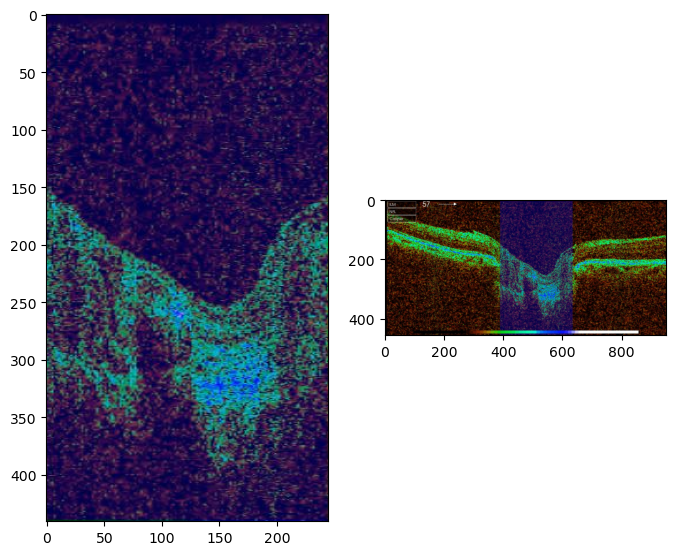

In [345]:
cropBSCAN(ptscans(11)[1],showMode='compare')

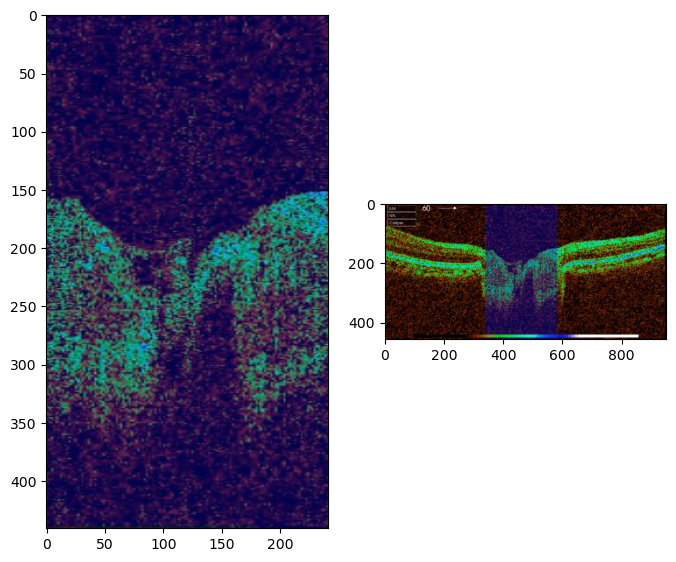

In [346]:
cropBSCAN(ptscans(11)[2],showMode='compare')

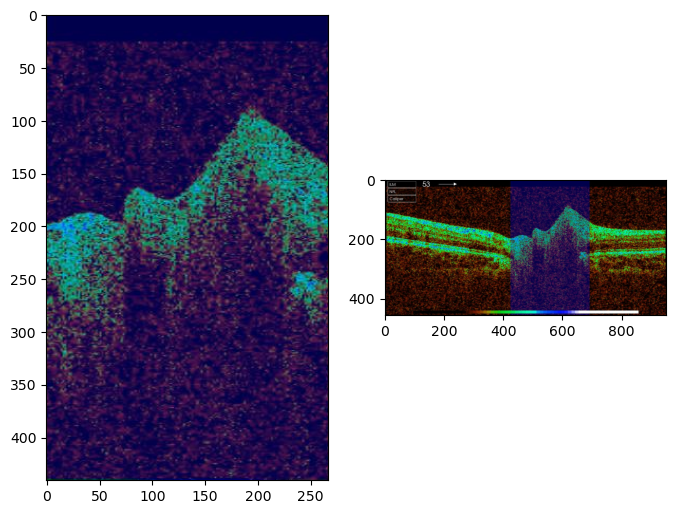

In [348]:
cropBSCAN(ptscans(11)[3],showMode='compare')

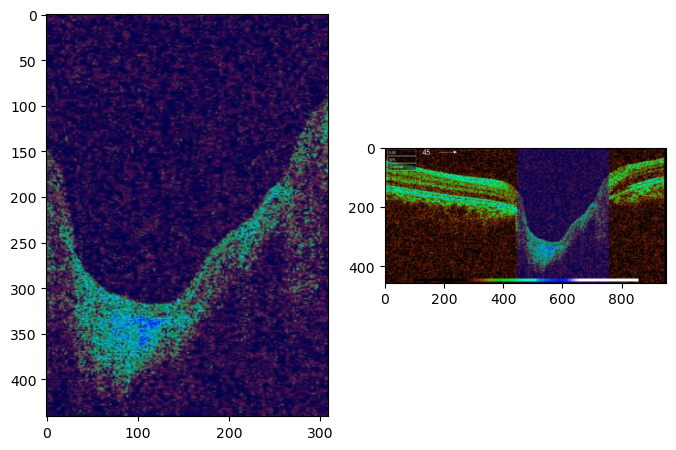

In [350]:
cropBSCAN(ptscans(12)[1],showMode='compare')

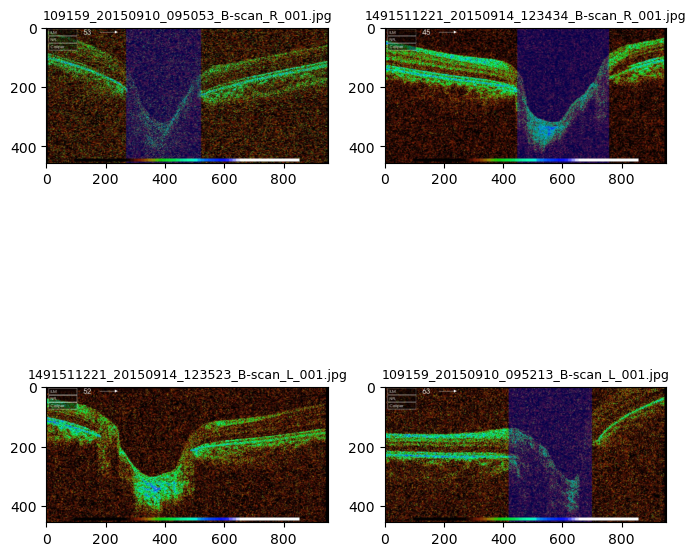

In [349]:
imPanelShow(ptscans(12))

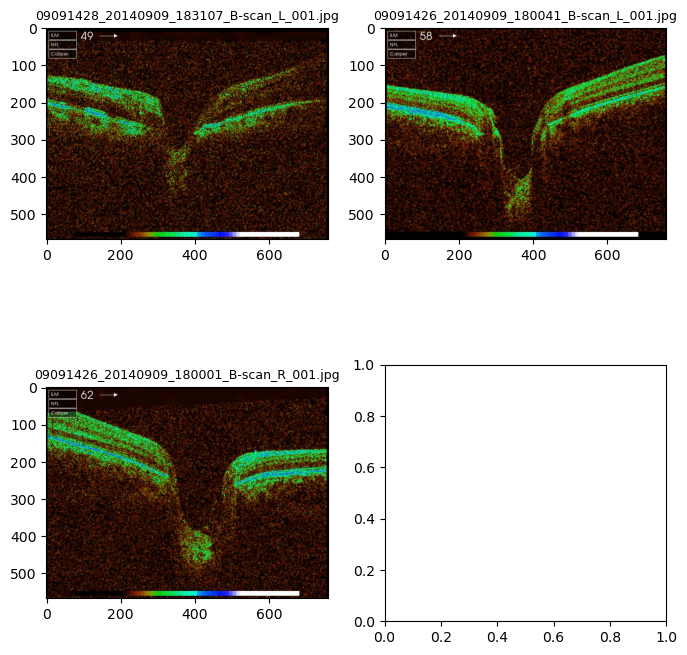

In [266]:
imPanelShow(ptscans(8))

In [365]:
bscanCROPPED = [cropBSCAN(p) for p in bscnPaths]
len(bscanCROPPED)

76

In [366]:
for i,img in enumerate(bscanCROPPED):
    fn = os.path.basename(bscnPaths[i])
    oDIR = os.path.dirname(bscnPaths[i])
    fn = f'{fn.split('.')[0]}-cropped.jpg'
    oPATH = os.path.join(oDIR,fn)
    if img.shape[1] > 0:
        cv2.imwrite(oPATH,img)

In [ ]:
oct2D[~oct2D['b-scan']]['filepath'].str.split('/').str[-1]

In [207]:
oct2D.filepath[oct2D.filepath.str.contains('Cyst')].iloc[0]

'../datasrc/fundus-oct-composite/Glaucoma/P_5/Left Eye/OCT_Left_ME_Cyst.jpg'

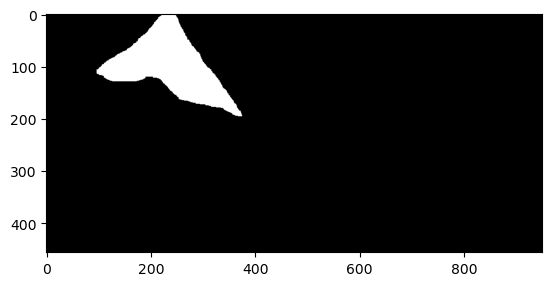

In [208]:
plt.imshow(cv2.imread(oct2D.filepath[oct2D.filepath.str.contains('Cyst')].iloc[0]))

In [213]:
[ p for p in set(octPaths) if 'P_5' in p ]

['../datasrc/fundus-oct-composite/Glaucoma/P_5/Left Eye/OCT_Left_ME_Cyst.jpg',
 '../datasrc/fundus-oct-composite/Glaucoma/P_5/Right Eye/109158787_20150910_124705_B-scan_R_001.jpg',
 '../datasrc/fundus-oct-composite/Healthy/P_5/Left Eye/149153434_20150914_115737_B-scan_L_001.jpg',
 '../datasrc/fundus-oct-composite/Healthy/P_5/Right Eye/149153434_20150914_115822_B-scan_R_001.jpg',
 '../datasrc/fundus-oct-composite/Glaucoma/P_5/Left Eye/109158787_20150910_124253_B-scan_L_001.jpg']

In [235]:
ptscans = lambda i : [ p for p in set(octPaths) if list(set(oct2D.pid))[i]+'/' in p ]
ptscans(6)

['../datasrc/fundus-oct-composite/Glaucoma/P_5/Left Eye/OCT_Left_ME_Cyst.jpg',
 '../datasrc/fundus-oct-composite/Glaucoma/P_5/Right Eye/109158787_20150910_124705_B-scan_R_001.jpg',
 '../datasrc/fundus-oct-composite/Healthy/P_5/Left Eye/149153434_20150914_115737_B-scan_L_001.jpg',
 '../datasrc/fundus-oct-composite/Healthy/P_5/Right Eye/149153434_20150914_115822_B-scan_R_001.jpg',
 '../datasrc/fundus-oct-composite/Glaucoma/P_5/Left Eye/109158787_20150910_124253_B-scan_L_001.jpg']

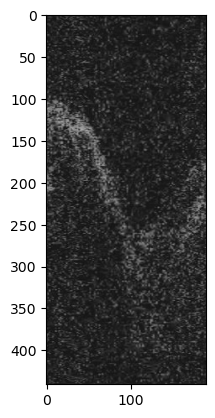

In [375]:
crpath = "../datasrc/fundus-oct-composite/CroppedBSCANs/"
grayimgs = [i for i in os.listdir(crpath) if 'gray' in i.lower() and i.endswith('jpg')]

gpths = [ os.path.join(crpath,i) for i in grayimgs ]

plt.imshow(cv2.imread(gpths[0]))


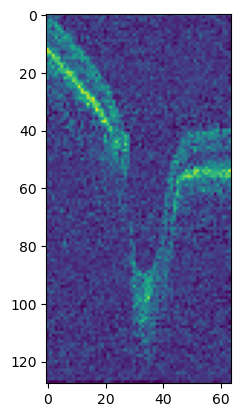

In [383]:
vp = os.path.join(vPATH, volNames[0])
vol = np.load(vp)
vslice = vol[32,:,:]
plt.imshow(vslice)

In [387]:
vslice.shape

(128, 64)

In [395]:
len(gpths)

46

In [399]:

len(gnames)

46

In [402]:
gnames = [f for f in os.listdir(crpath) if 'gray' in f.lower() and f.endswith('jpg')]
gpths = [ os.path.join(crpath,gn) for gn in gnames ] 
grays = [cv2.cvtColor(cv2.imread(g),cv2.COLOR_BGR2GRAY) for g in gpths]

for i,g in enumerate(grays):
    h, w = g.shape[:2]
    scale = 64 / min(h, w)
    resized = cv2.resize(g, (int(w * scale), int(h * scale)))
    fn = gnames[i]
    fn = fn.split('.jpg')[0]+'-DOWNSCALED.jpg'
    oPATH = os.path.join(crpath,fn)
    cv2.imwrite(oPATH,g)

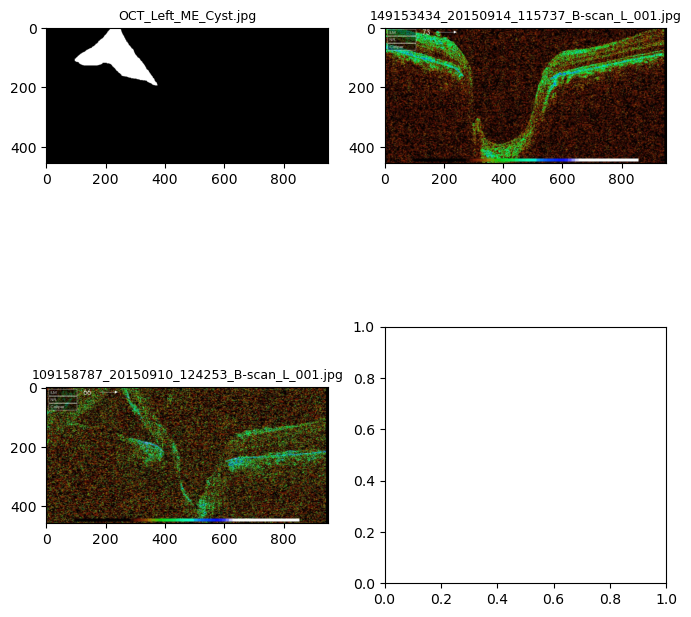

In [248]:
pt5L = [ p for p in ptscans(6) if 'Left' in p ]

imPanelShow(pt5L)

In [106]:
idx = 3
si0 = list(sample_imgs.values())[idx]
len([p for p in imgPaths if si0 in p])

13

In [92]:
for i in sample_imgs.values():
    cv2.imread(os.path.join(iPATH,subpaths

dict_values(['99144_20140909_173003_Color_R_001.jpg', '99144_20140909_173003_B-scan_R_001.jpg', '99144_20140909_173003_Red-free_R_001.jpg', 'Fundus_Right_Glaucoma_Cup.jpg', 'Fundus_Right_Glaucoma_Cup.jpg', 'OCT_Right_Glaucoma_Cup.jpg', 'Fundus_Right_Glaucoma_Disc.jpg'])

In [ ]:
OCTsubpaths = [ sp for sp in subpaths if 'Fundus' not in sp ]
print(len(OCTsubpaths))
OCTsubpaths[mid-20:mid]

## 3.2 | Column Names & Descriptions

## 3.3 | Data Types

## 3.4 | Counts, Percentages, & Ranges

## 3.5 | Brief Exploration of Volumes / Images

### 3.5.1 | Shapes & Dimensions

### 3.5.2 | Axes & Orientations  

# 4 | Data Cleaning

## 4.1 | Missing Data 

## 4.2 | Duplicates

# 5 | Saving & Summary